# Using Genomics (TCGA) Data to train cancer classification models

## 1. Import dependencies

In [26]:
import numpy as np, pandas as pd
import traceback, os
import requests
from tqdm import tqdm

### 2. load preprocessed data from TCGA Pan-Caner Atlas project - for details on pipeline see https://pancanatlas.xenahubs.net/

In [2]:
tcga_data_url = "https://github.com/cognoma/cancer-data/blob/master/download/EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena.tsv.gz?raw=true"
tcga_annot_url = "https://pancanatlas.xenahubs.net/download/TCGA_phenotype_denseDataOnlyDownload.tsv.gz"
tcga_output_path = "TCGAdata/TCGApancanRNA.gz"
tcga_annot_output_path = "TCGAdata/TCGAannot.gz"

In [22]:
bucket = 'who-cancer-classification-data'

## 3. Download TCGA Data and Upload to S3

#### Create local directories for downloading data

In [5]:
try:
    os.mkdir("TCGAdata")
except:
    traceback.print_exc()
    
try:
    os.mkdir("GTExdata")
except:
    traceback.print_exc()

#### Write a download function

In [4]:
def downloader(url, output_path):
    print(f"Downloading",url)

    r = requests.get(url, stream=True)

    total_size = int(r.headers.get("content-length", 0))
    block_size = 1024

    t = tqdm(total=total_size, unit="iB", unit_scale=True)

    with open(output_path, "wb") as f:
        for data in r.iter_content(block_size):
            t.update(len(data))
            f.write(data)

    t.close()

#### Download and unzip files

In [7]:
downloader(tcga_data_url, tcga_output_path)

100%|██████████| 331M/331M [00:08<00:00, 38.0MiB/s] 


In [8]:
downloader(tcga_annot_url, tcga_annot_output_path)

  0%|          | 0.00/61.2k [00:00<?, ?iB/s]

100%|██████████| 61.2k/61.2k [00:00<00:00, 3.47MiB/s]


In [10]:
!gunzip TCGAdata/*.gz

gzip: TCGAdata/*.gz: No such file or directory


#### Upload files to S3

In [11]:
import boto3, os
boto3.Session().resource('s3').Bucket(bucket).Object('input/TCGApancanRNA').upload_file('TCGAdata/TCGApancanRNA')

In [12]:
boto3.Session().resource('s3').Bucket(bucket).Object('input/TCGAannot').upload_file('TCGAdata/TCGAannot')

## 4. Download GTex data and upload to S3

In [13]:
# see https://www.gtexportal.org/home/datasets
gtex_data_url = "https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz"
gtex_output_path = "GTExdata/GTExdata.gz"
#https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-2919/
gtex_annot_url_1 = "https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-2919/E-MTAB-2919.sdrf.txt"
gtex_annot_url_2 = "https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-5214/E-MTAB-5214.sdrf.txt"
gtex_annot_output_path1, gtex_annot_output_path2 = "GTExdata/"+gtex_annot_url_1.split("/")[-1], "GTExdata/"+gtex_annot_url_2.split("/")[-1]

In [14]:
downloader(gtex_data_url, gtex_output_path)
downloader(gtex_annot_url_1, gtex_annot_output_path1)
downloader(gtex_annot_url_2, gtex_annot_output_path2)

  0%|          | 0.00/1.63G [00:00<?, ?iB/s]

100%|██████████| 1.63G/1.63G [00:38<00:00, 42.3MiB/s]


100%|██████████| 2.42M/2.42M [00:01<00:00, 1.27MiB/s]


100%|██████████| 15.3M/15.3M [00:03<00:00, 4.22MiB/s]


#### Unzip the file(s)

In [15]:
!gunzip GTExdata/*.gz

#### Upload the data to S3

In [16]:
gtex_data = boto3.Session().resource('s3').Bucket(bucket).Object('input/GTExdata').upload_file('GTExdata/GTExdata')

In [17]:
gtex_annot_data1 = boto3.Session().resource('s3').Bucket(bucket).Object('input/E-MTAB-2919.sdrf.txt').upload_file('GTExdata/E-MTAB-2919.sdrf.txt')

In [18]:
gtex_annot_data2 = boto3.Session().resource('s3').Bucket(bucket).Object('input/E-MTAB-5214.sdrf.txt').upload_file('GTExdata/E-MTAB-5214.sdrf.txt')

## 5. Process TCGA and GTex Data using SageMaker Processing
In the next few steps we will prepare a sagemaker processing script and run a SageMaker Processing job using the built-in SageMaker Scikit Learn container

Create the processing script.

In [8]:
%%writefile preprocessing.py


import argparse
import os
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import time, pickle
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


# tumor abbreviations map
TCGA_MAP = {
    "acute myeloid leukemia": "LAML",
    "adrenocortical cancer": "ACC",
    "bladder urothelial carcinoma": "BLCA",
    "brain lower grade glioma": "LGG",
    "breast invasive carcinoma": "BRCA",
    "cervical & endocervical cancer": "CESC",
    "cholangiocarcinoma": "CHOL",
    "colon adenocarcinoma": "COAD",
    "diffuse large B-cell lymphoma": "DLBC",
    "esophageal carcinoma": "ESCA",
    "glioblastoma multiforme": "GBM",
    "head & neck squamous cell carcinoma": "HNSC",
    "kidney chromophobe": "KICH",
    "kidney clear cell carcinoma": "KIRC",
    "kidney papillary cell carcinoma": "KIRP",
    "liver hepatocellular carcinoma": "LIHC",
    "lung adenocarcinoma": "LUAD",
    "lung squamous cell carcinoma": "LUSC",
    "mesothelioma": "MESO",
    "ovarian serous cystadenocarcinoma": "OV",
    "pancreatic adenocarcinoma": "PAAD",
    "pheochromocytoma & paraganglioma": "PCPG",
    "prostate adenocarcinoma": "PRAD",
    "rectum adenocarcinoma": "READ",
    "sarcoma": "SARC",
    "skin cutaneous melanoma": "SKCM",
    "stomach adenocarcinoma": "STAD",
    "testicular germ cell tumor": "TGCT",
    "thymoma": "THYM",
    "thyroid carcinoma": "THCA",
    "uterine carcinosarcoma": "UCS",
    "uterine corpus endometrioid carcinoma": "UCEC",
    "uveal melanoma": "UVM",
}

if __name__=='__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train-test-split-ratio', type=float, default=0.3)
    args, _ = parser.parse_known_args()
    
    print('Received arguments {}'.format(args))

    tcga_input_path = os.path.join('/opt/ml/processing/input', 'TCGApancanRNA')

    tcga_annot_input_path = os.path.join('/opt/ml/processing/input', 'TCGAannot')
    
    gtex_input_path = os.path.join('/opt/ml/processing/input', 'GTExdata')

    gtex_annot_input_path_1 = os.path.join('/opt/ml/processing/input', 'E-MTAB-2919.sdrf.txt')

    gtex_annot_input_path_2 = os.path.join('/opt/ml/processing/input', 'E-MTAB-5214.sdrf.txt')

    
    tcga_df = pd.read_csv(tcga_input_path, sep="\t", index_col=0)
    print('Reading input data from {}'.format(tcga_input_path))

    tcga_df = tcga_df.T
    tcga_df.columns = [tcga_df.columns[i] + "_" + str(i) for i in range(len(tcga_df.columns))]

    tcga_df = tcga_df.astype(np.float16)

    print('Reading input data from {}'.format(tcga_annot_input_path))
    df = pd.read_csv(tcga_annot_input_path, sep="\t", index_col=0)

    print('Start processing TCGA Data')

    df["abbreviated_disease"] = df["_primary_disease"].apply(lambda x: TCGA_MAP[x])

    str_cols = ["sample_type", "_primary_disease", "abbreviated_disease"]

    for col in str_cols:

        df[col] = df[col].astype(str)

    df.index = df.index.astype(str)
    df.abbreviated_disease = pd.Categorical(df.abbreviated_disease)
    annot_df = df
    
    print('Join TCGA RNA and Annotation')

    tdf = tcga_df.join(annot_df, how="inner")
    tcga_y = 1+tdf.abbreviated_disease.cat.codes.values
    tcga_diseases = tdf.abbreviated_disease
    tdf = tdf.iloc[:,:-annot_df.shape[1]]
    
    import pandas as pd
    from importlib import reload
    reload(pd)

    print('Reading input data from {}'.format(gtex_input_path))

    gtex_df = pd.read_csv(gtex_input_path, skiprows=2, index_col=0, sep="\t")
    gtex_df.index = gtex_df["Description"].str.cat(["_"+v for v in gtex_df.index.values])
    gtex_df.drop(["Description"], axis=1, inplace=True)
    gtex_df = gtex_df.T

    gtex_df = np.log2(gtex_df + 1)
    gtex_df = gtex_df.astype(np.float16)
    
    print('Reading input data from {}'.format(gtex_annot_input_path_1))

    gtex_annot_df = pd.concat([pd.read_csv(gtex_annot_input_path_1, sep="\t"), pd.read_csv(gtex_annot_input_path_2, sep="\t")], axis=0, sort=True)
    
    print('Starting to process GTExdata')

    gtex_annot_df = gtex_annot_df.set_index("Source Name")
    gtex_annot_df = gtex_annot_df[~gtex_annot_df.index.duplicated(keep='first')]
    gdf = gtex_df.join(gtex_annot_df, how="inner")
    gdf = gdf.iloc[:,:gtex_df.shape[1]]
    
    print('Finding Common Genes')
    gtextgenes = [x.split("_")[0] for x in gdf.columns]
    tcgagenes = [x.split("_")[0] for x in tdf.columns]
    common_genes = np.intersect1d(gtextgenes, tcgagenes).tolist()

    # get rid of unused suffixes to harmonize column names
    t,g = tdf.rename(columns=lambda x: x.split("_")[0])[common_genes], gdf.rename(columns=lambda x: x.split("_")[0])[common_genes]

    # get rid of duplicate columns
    
    # get rid of duplicate columns
    def drop_duplicate_columns(d):
        uq, cnt = np.unique(d.columns,return_counts=True)
        duplicates = np.where(cnt>1)[0]
        return d.drop(uq[duplicates],axis=1)
    t,g = drop_duplicate_columns(t), drop_duplicate_columns(g)
    
    # find intersection (common columns)
    common_genes = np.intersect1d(t.columns, g.columns).tolist()
    print(t[common_genes].shape,g[common_genes].shape)

    # concatenate
    df = pd.concat((t[common_genes], g[common_genes]), axis=0)
    print(df.shape)

    print('Concatenate data sets')

    y = np.concatenate((tcga_y, [0]*len(gdf)))
    
    from scipy.stats import itemfreq
    F =  itemfreq(tcga_diseases)
    print(F)
    
    F = F[np.argsort(F[:,-1])[::-1]]
    print(F)
    
    classes, cnt = np.unique(y, return_counts=True)
    most_freq_count_idx = np.argsort(cnt)[::-1][:6]
    most_freq_cls = list(classes[most_freq_count_idx])
    idx5 = [i for i in range(len(y)) if y[i] in most_freq_cls and y[i] != 0]
    y5 = np.array([most_freq_cls.index(c) for c in y[idx5]])

    print('Size of y5: '+str(y5.size))

    all_model_df = df.iloc[idx5]
    print('Size of x: '+str(all_model_df.shape))
    
    #all_model_df.reset_index().to_feather("all_model_df.feather")
    nans = all_model_df.isna()
    drop_features = []

    for c in np.unique(y5):
        feature_wise_nan_prevalence_c = nans[y5==c].mean(0)
        feature_wise_nan_prevalence_nonc = nans[y5!=c].mean(0)
        nan_is_discriminative = np.where(feature_wise_nan_prevalence_nonc != feature_wise_nan_prevalence_c)[0]
        drop_features += list(nan_is_discriminative)
        print(c,len(nan_is_discriminative))
    
    print(all_model_df.shape)
    all_model_df.drop(all_model_df.columns[np.unique(drop_features)],axis=1,inplace=True)
    print(all_model_df.shape)
    
    y_features_output_path = os.path.join('/opt/ml/processing/train', 'y5.npy')
    all_model_df_output_path = os.path.join('/opt/ml/processing/train', 'all_model_df.csv')
    
    print('Saving y features to {}'.format(y_features_output_path))
    np.save(y_features_output_path,y5)

    #pd.DataFrame(y5).to_csv(y_features_output_path, header=False, index=False)
    
    print('Saving all model df features to {}'.format(all_model_df_output_path))
    pd.DataFrame(all_model_df).to_csv(all_model_df_output_path, header=True, index=False)

Overwriting preprocessing.py


#### Start a new SM session and initiate SKLearnProcessor
While initiating SKlearnProcessor, we will specify the following:
* framework version
* instance type
* instance count

In [27]:
import boto3
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor

region = boto3.session.Session().region_name

role = get_execution_role()
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.m5.24xlarge',
                                     instance_count=1)

#### Submit the processing job using the processing script

In [10]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor.run(code='preprocessing.py',
                      inputs=[ProcessingInput(
                        source='s3://'+bucket+'/input',
                        destination='/opt/ml/processing/input')],
                      outputs=[ProcessingOutput(output_name='train_data',
                                                source='/opt/ml/processing/train',
                                               destination='s3://'+bucket+'/model_input')],
                      arguments=['--train-test-split-ratio', '0.2']
                     )

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    if output['OutputName'] == 'train_data':
        preprocessed_training_data = output['S3Output']['S3Uri']


Job Name:  sagemaker-scikit-learn-2021-04-13-10-04-24-348
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://who-cancer-classification-data/input', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-463045133778/sagemaker-scikit-learn-2021-04-13-10-04-24-348/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://who-cancer-classification-data/model_input', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}]
................................./miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib

### 6. Train a LightGBM Model Using Custom Container
In the next step, we will use the output from SageMaker Processing Job to train a LightGBM model

In [63]:
import sagemaker as sage
from time import gmtime, strftime

sess = sage.Session()

In [64]:
inputs = 's3://'+bucket+'/model_input'

In [65]:
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/genomics-cancer-classification-lightgbm:latest'.format(account, region)

tree = sage.estimator.Estimator(image,
                                role, 
                                1, 
                                'ml.m5.24xlarge',
                                output_path="s3://{}/lightgbm_output".format(bucket),
                                hyperparameters = {'n-features': 100, 'block-size': 5, 'max-allowed': 5},
                                metric_definitions=[
                                    {'Name': 'accuracy', 'Regex': 'accuracy=(.*?);'}
                                ],
                                enable_sagemaker_metrics=True,
                               sagemaker_session=sess)

tree.fit(inputs)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-05-07 22:39:49 Starting - Starting the training job...
2021-05-07 22:39:51 Starting - Launching requested ML instances......
2021-05-07 22:41:10 Starting - Preparing the instances for training......
2021-05-07 22:42:05 Downloading - Downloading input data...
2021-05-07 22:42:26 Training - Downloading the training image...
2021-05-07 22:43:20 Training - Training image download completed. Training in progress..2021-05-07 22:43:21,088 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-07 22:43:24,140 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-07 22:43:24,154 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-07 22:43:24,165 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "

In [66]:
import matplotlib.pyplot as plt
from sagemaker.analytics import TrainingJobAnalytics
training_job_name = tree.latest_training_job.job_name

accuracy_df = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=['accuracy']).dataframe()

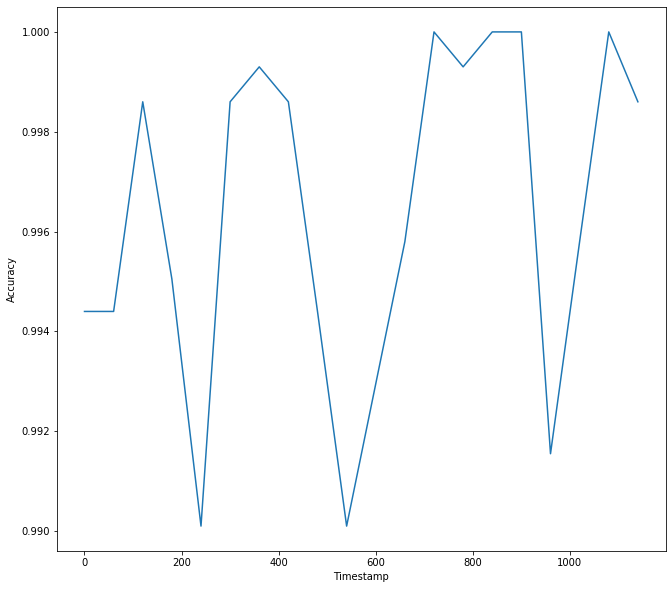

In [67]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(1, 2, 1)

ax1.plot(accuracy_df['timestamp'], accuracy_df['value'])

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Accuracy')

plt.figsize = (18,10)

plt.show()

In [68]:
 tree.latest_training_job.name

'genomics-cancer-classification-lightgbm-2021-05-07-22-39-49-627'

#### Copy the model binaries to input folder in S3 for the next training run

In [73]:
lightgbm_model_output = tree.latest_training_job.name +'/output/model.tar.gz'

In [74]:
try:
    os.mkdir("lightgbm_models")
except:
    traceback.print_exc()

In [75]:
boto3.Session().resource('s3').Bucket(bucket).download_file('lightgbm_output/'+lightgbm_model_output, 'lightgbm_models/model.tar.gz')

In [76]:
!tar -zxf lightgbm_models/model.tar.gz --directory lightgbm_models

In [77]:
input_files = []
for file in os.listdir("lightgbm_models"):
    if file.endswith("100ft.b"):
        boto3.Session().resource('s3').Bucket(bucket).Object('model_input/'+file).upload_file(os.path.join("lightgbm_models", file))
        input_files.append(os.path.join("lightgbm_models", file))

### Run Hyperparameter Tuning

In [39]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
import datetime

tuning_job_name = "cancer-cls-job-{}".format(datetime.datetime.now().strftime("%d-%H-%M-%S"))

            
hyperparameter_ranges = {'n-features': IntegerParameter(100, 120),
                         'block-size': IntegerParameter(5, 6),
                         'max-allowed': IntegerParameter(5, 6)}

objective_metric_name = 'accuracy'

metric_definitions=[
                               {'Name': 'accuracy', 'Regex': 'accuracy=(.*?);'}
                            ]

tuner = HyperparameterTuner(tree, 
                            objective_metric_name, 
                            hyperparameter_ranges,
                            metric_definitions,
                            objective_type='Maximize', 
                            max_jobs=20, 
                            max_parallel_jobs=2,
                            early_stopping_type='Auto')

In [40]:
tuner.fit(inputs, 
          job_name=tuning_job_name, include_cls_metadata=False)
tuner.wait()

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## 6. Train with AutoGluon

In [78]:
image = '{}.dkr.ecr.{}.amazonaws.com/genomics-cancer-classification-autogluon:latest'.format(account, region)

tree = sage.estimator.Estimator(image,
                       role, 1, 'ml.m5.24xlarge',
                       output_path="s3://{}/autogluon_output".format(bucket),
                       sagemaker_session=sess)

tree.fit('s3://'+bucket+'/model_input')

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-05-07 23:32:02 Starting - Starting the training job...
2021-05-07 23:32:04 Starting - Launching requested ML instances......
2021-05-07 23:33:16 Starting - Preparing the instances for training......
2021-05-07 23:34:10 Downloading - Downloading input data......
2021-05-07 23:35:13 Training - Downloading the training image........2021-05-07 23:36:44,485 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-05-07 23:36:44,488 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-07 23:36:44,498 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"training":{"RecordWrapperType":"None","S3DistributionType":"FullyReplicate

In [79]:
tree.output_path

's3://who-cancer-classification-data/autogluon_output'

In [80]:
tree.latest_training_job.name

'genomics-cancer-classification-autogluo-2021-05-07-23-32-02-100'

In [82]:
autogluon_model_output = tree.latest_training_job.name +'/output/model.tar.gz'
#autogluon_model_output = 's3://sagemaker-us-east-1-463045133778/output/genomics-cancer-classification-autogluo-2021-04-14-14-09-42-148/output/model.tar.gz'

In [83]:
try:
    os.mkdir("autogluon_models")
except:
    traceback.print_exc()

In [84]:
boto3.Session().resource('s3').Bucket(bucket).download_file('autogluon_output/'+autogluon_model_output, 'autogluon_models/model.tar.gz')
#boto3.Session().resource('s3').Bucket('sagemaker-us-east-1-463045133778').download_file('output/genomics-cancer-classification-autogluo-2021-04-14-14-09-42-148/output/model.tar.gz', 'autogluon_models/model.tar.gz')

In [85]:
!tar -zxf autogluon_models/model.tar.gz --directory autogluon_models

# 7. Train with interpretable machine learning classifiers

In [ ]:
account = sess.boto_session.client('sts').get_caller_identity()['Account']

image = '{}.dkr.ecr.{}.amazonaws.com/genomics-cancer-classification-imodels:latest'.format(account, region)

tree = sage.estimator.Estimator(image,
                       role, 1, 'ml.m5.24xlarge',
                       output_path="s3://{}/imodels-output".format(bucket),
                       sagemaker_session=sess)

tree.fit('s3://'+bucket+'/model_input')

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-05-08 01:38:33 Starting - Starting the training job...
2021-05-08 01:38:34 Starting - Launching requested ML instances......
2021-05-08 01:39:46 Starting - Preparing the instances for training......
2021-05-08 01:40:48 Downloading - Downloading input data...
2021-05-08 01:41:30 Training - Downloading the training image.......2021-05-08 01:42:37,149 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-05-08 01:42:37,152 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-08 01:42:37,164 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"training":{"RecordWrapperType":"None","S3DistributionType":"FullyReplicated","

In [91]:
tree.output_path

's3://who-cancer-classification-data/imodels-output'

In [92]:
tree.latest_training_job.name

'genomics-cancer-classification-imodels-2021-05-08-01-38-32-988'

In [93]:
imodels_model_output = tree.latest_training_job.name +'/output/model.tar.gz'
#imodels_model_output = 's3://' + bucket + 'sagemaker-us-east-1-463045133778/imodels-output/genomics-cancer-classification-imodels-2021-04-14-15-57-53-704/output/model.tar.gz'

In [94]:
try:
    os.mkdir("imodels_models")
except:
    traceback.print_exc()

Traceback (most recent call last):
  File "<ipython-input-94-6eae7092e9a2>", line 2, in <module>
    os.mkdir("imodels_models")
FileExistsError: [Errno 17] File exists: 'imodels_models'


In [98]:
boto3.Session().resource('s3').Bucket(bucket).download_file('imodels-output/'+imodels_model_output, 'imodels_models/model.tar.gz')
#boto3.Session().resource('s3').Bucket(bucket).download_file('imodels-output/genomics-cancer-classification-imodels-2021-04-14-15-57-53-704/output/model.tar.gz', 'imodels_models/model.tar.gz')

In [99]:
!tar -zxf imodels_models/model.tar.gz --directory imodels_models

# Show Results

In [87]:
import glob, pickle

# LGBM Results

In [89]:
from lightgbm.sklearn import LGBMClassifier
import biomarkerdetector
for c in range(6):
    accs = []
    for fn in glob.glob("lightgbm_models/c"+str(c)+"*acc.b"):
        with open(fn, "rb") as fp: 
            acc = pickle.load(fp)
        accs.append(acc)
    print("LGBM:",c,np.mean(accs),np.std(accs)/np.sqrt(5))

LGBM: 0 nan nan
LGBM: 1 0.9954794268773124 0.0009280517529450903
LGBM: 2 0.9971747416872437 0.0015979108326774029
LGBM: 3 0.9932191403159687 0.0018040375774600389
LGBM: 4 0.9997175141242938 0.0002526630483050537
LGBM: 5 0.9954798264330064 0.0017594534321178487


# AutoML Results

In [90]:
import glob, pickle
for c in range(6):
    accs = []
    for fn in glob.glob("autogluon_models/AutoML_c"+str(c)+"*acc.b"):
        with open(fn, "rb") as fp: 
            bacc = pickle.load(fp)
        accs.append(bacc)
        
    print("AutoML:",c,np.mean(accs),np.std(accs)/np.sqrt(5))

AutoML: 0 nan nan
AutoML: 1 0.9966093703801372 0.00030915666689754835
AutoML: 2 0.9980221993143624 0.0011715118762471097
AutoML: 3 0.9946319692501939 0.00175936372879127
AutoML: 4 0.9997175141242938 0.0002526630483050537
AutoML: 5 0.9943490838187934 0.0018736189087527142


# Interpretable Rule List Result

In [101]:
for c in range(6):
    accs = []
    for fn in glob.glob("imodels_models/BRL_c"+str(c)+"*acc.b"):
        with open(fn, "rb") as fp: 
            bacc = pickle.load(fp)
        accs.append(bacc)
        
    print(c,np.mean(accs),np.std(accs)/np.sqrt(5))
    #print(clf.tostring())
    print()

0 nan nan

1 0.9864350841863846 0.0024197445806246214

2 0.992371283133156 0.0019404165159039638

3 0.9892647376117758 0.002513462796769829

4 0.9988700564971751 0.00073663304013589

5 0.9889790552905169 0.0018920733324475402

